## Lab 6: Resampling and the Bootstrap

Welcome to Lab 6! This lab is due on **Thursday, May 20 at 11:59pm.**

In lecture, we saw an example of *estimation*.  In WWII, the Allies wanted to know how many warplanes the Germans had (some number `N`, a *population parameter*), and they needed to estimate that quantity knowing only a random sample of the planes' serial numbers (from 1 to `N`).  For example, one estimate was twice the mean of the sample serial numbers.

We investigated the random variation in these estimates by simulating sampling from the population many times and computing estimates from each sample.  In real life, if the Allies had known what the population looked like, they would have known `N` and would not have had any reason to think about random sampling.  They didn't know what the population looked like, so they couldn't have run the simulations we did.  So that was useful as an exercise in *understanding random variation* in an estimate, but not as a tool for practical data analysis.

Now we'll flip that idea on its head to make it practical.  Given *just* a random sample of serial numbers, we'll estimate `N`, and then we'll use simulation to find out how accurate our estimate probably is, without ever looking at the whole population.  This is an example of *statistical inference*.

As usual, **run the cell below** to prepare the lab and the automatic tests.

In [1]:
import numpy as np
import babypandas as bpd
import math

# These lines set up graphing capabilities.
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import otter
grader = otter.Notebook()

## 0. Percentiles
Numerical data can be sorted in increasing or decreasing order. Thus the values of a numerical data set have some rank order. A `percentile` is the value at a particular rank. The p`th` percentile is the value in the set that is at least as large as p% of the elements in the set.

#### Question 0.1

Say, you are in a class with 10 students and the grades of all students in the class are stored in the array `grades`. Your score is 84. 

Which of the following statements are true?

1. The highest score is the 100th percentile 
2. Your score is more than 80th percentile
3. Your score is less than 81st percentile
4. Your score is less than 90th percentile
5. 78 is the 50th percentile

Assign `true_percentile` to a list of the correct statements.

In [2]:
grades = np.array([56, 65, 67, 72, 74, 78, 78, 80, 84, 94])

In [3]:
true_percentile  = [1,2,4]
true_percentile

[1, 2, 4]

In [4]:
grader.check("q01")

q01 passed!

#### Question 0.2
The `percentile` function takes two arguments: a rank between 0 and 100, and an array. It returns the corresponding percentile of the array: `percentile(array, rank)`. Calculate the 50`th` percentile of the `grades` array using the `percentile` function.

In [5]:
p_50 = np.percentile(grades, 50)
p_50

76.0

In [6]:
grader.check("q02")

q02 passed!

#### Question 0.3
Calculate the median value of the `grades` array and **manually** compare it to your answer from `Question 0.2`. Set variable `same` to `True` if the two values are the same, and `False` if they are different. Do not use if/else for this question.  

In [7]:
median = np.median(grades)
print(median)
same = True

76.0


In [8]:
grader.check("q03")

q03 passed!

## 1. Preliminaries
Remember the setup: We (the Allies in World War II) want to know the number of warplanes fielded by the Germans.  That number is `N`.  The warplanes have serial numbers from 1 to `N`, so `N` is also equal to the largest serial number on any of the warplanes.

We only see a small number of serial numbers (assumed to be a random sample with replacement from among all the serial numbers), so we have to use estimation.

#### Question 1.1
Is `N` a population parameter or a statistic?  If we compute a number using our random sample that's an estimate of `N`, is that a population parameter or a statistic?  Assign either 1, 2, 3, or 4 to the variable `preliminaries_q1` below. 
1. `N` is a population parameter.  An estimate of `N` from our random sample is a population perameter.
2. `N` is a population parameter.  An estimate of `N` from our random sample is a statistic.
3. `N` is a statistic.  An estimate of `N` from our random sample is a population parameter.
4. `N` is a statistic.  An estimate of `N` from our random sample is a statistic.

In [9]:
preliminaries_q1 = 2

In [10]:
grader.check("q11")

q11 passed!

To make the situation realistic, we're going to hide the true number of warplanes from you.  You'll have access only to this random sample:

In [11]:
observations = bpd.read_csv("data/serial_numbers.csv")
num_observations = observations.shape[0]
observations

,serial_number
0,47
1,42
2,57
3,79
4,26
...,...
12,67
13,108
14,84
15,50


#### Question 1.2
Define a function named `plot_serial_numbers` to make a histogram of any table of serial numbers.  It should take one argument, a table like `observations` with one column called `"serial_number"`.  It should plot a histogram of the values in the column **using bins of width 1** ranging from **1 to 200** but return nothing.  Then, call that function to make a histogram of `observations`.

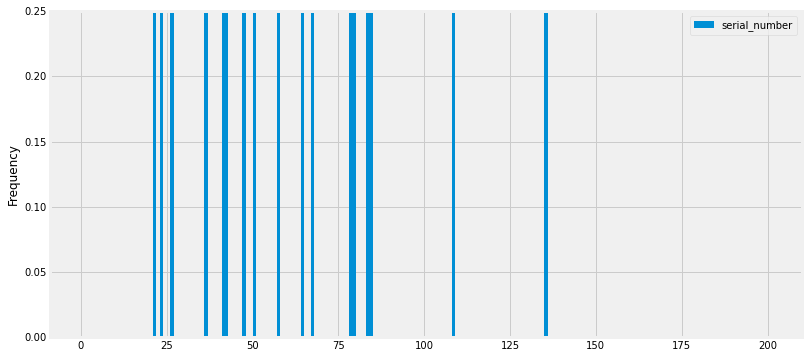

In [12]:
def plot_serial_numbers(numbers):
    bins = np.arange(1,201,1)
    numbers.plot(kind='hist', bins=bins, figsize=[12,6])
    # Assuming the lines above produce a histogram, this next
    # line may make your histograms look nicer.  Feel free to
    # delete it if you want.
    plt.ylim(0, .25)

plot_serial_numbers(observations)

***Check your answer***: Your histogram should have bars that are all the same height and the plot's x axis should read "serial_number" and have a range starting from 0 and ending at 200

#### Question 1.3
Why are all the bars the same height, and will they always be?  Think about why this is the case.  Assign either 1, 2, 3, or 4 to the variable `preliminaries_q3` below. 
1. Each serial number is in a bin of width 1, and all bins need to have the same area, so all of the bars are the same height. In general, the bars will always be the same height for a set of observations.
2. Each serial number has the same length, so all of the bars are the same height. In general, all of the bars will always have the same height for a set of observations.
3. Each serial number shows up the same number of times in this set of observations, so all of the bars are the same height. In general, the bars might have different heights for another set of observations.
4. Each serial number shows up once in this set of observations, so all of the bars are the same height. In general, the bars will always have the same height for a set of observations.

In [13]:
preliminaries_q3 = 3

In [14]:
grader.check("q13")

q13 passed!

#### Question 1.4
In lecture, we saw that one way to estimate `N` was to take twice the mean of the serial numbers we see. Write a function that computes that statistic.  It should take as its argument an array of serial numbers and return twice their mean.  Call it `mean_based_estimator`.  

After that, use it to compute an estimate of `N` called `mean_based_estimate`.

In [15]:
def mean_based_estimator(nums):
    mean = np.mean(nums)
    return mean * 2

sample = np.array([])
for i in np.arange(observations.shape[0]):
    sample = np.append(sample,observations.get('serial_number').iloc[i])

mean_based_estimate = mean_based_estimator(sample)
mean_based_estimate

122.47058823529412

In [16]:
grader.check("q14")

q14 passed!

#### Question 1.5
We also estimated `N` using the biggest serial number in the sample.  Compute it, giving it the name `max_estimate`.

In [17]:
max_estimate = observations.get('serial_number').max()
max_estimate

135

In [18]:
grader.check("q15")

q15 passed!

#### Question 1.6
Look at the values of `max_estimate` and `mean_based_estimate` that we happened to get for our dataset.  The value of `max_estimate` tells you something about `mean_based_estimate`.  Could our current `mean_based_estimate` possibly be equal to `N` (at least if we round it to the nearest integer)?  If not, is it definitely higher, definitely lower, or can we not tell?  Assign one of the choices (`1 - 6`) to the variable `preliminaries_q6` below. 
1. Yes, our `mean_based_estimate` for this sample could equal `N`.
2. No, our `mean_based_estimate` for this sample cannot be equal to `N`, it is definitely lower by roughly 3.
3. No, our `mean_based_estimate` for this sample cannot be equal to `N`, it is definitely lower by at least 12.
4. No, our `mean_based_estimate` for this sample cannot be equal to `N`, it is definitely higher by roughly 3.
5. No, our `mean_based_estimate` for this sample cannot be equal to `N`, it is definitely higher by at least 12.
6. No, our `mean_based_estimate` for this sample cannot be equal to `N`, but we cannot tell if it is lower or higher.

In [19]:
preliminaries_q6 = 3

In [20]:
grader.check("q16")

q16 passed!

We can't just confidently proclaim that `max_estimate` or `mean_based_estimate` is equal to `N`.  What if we're really far off?  So we want to get a sense of the accuracy of our estimates.

## 2. Resampling
Therefore, we'll use resampling.  That is, we won't exactly simulate the observations the Allies would have really seen.  Rather we sample from our sample, or "resample."

Why does that make any sense?

When we tried to estimate `N`, we would have liked to use the whole population.  Since we had only a sample, we used that to estimate `N` instead.

This time, we would like to use the population of serial numbers to *run a simulation* about estimates of `N`.  But we still only have our sample.  We use our sample in place of the population to run the simulation.

So there is a simple analogy between estimating `N` and simulating the variability of estimates.

$$\text{computing }N\text{ from the population}$$
$$:$$
$$\text{computing an estimate of }N\text{ from a sample}$$

$$\text{as}$$

$$\text{simulating the distribution of estimates of }N\text{ using samples from the population}$$
$$:$$
$$\text{simulating an (approximate) distribution of estimates of }N\text{ using resamples from a sample}$$

#### Question 2.1
Write a function called `simulate_resample`.  It should generate a resample from the observed serial numbers in `observations` and return that resample.  (The resample should be a table like `observations`.)  It should take no arguments.

In [21]:
def simulate_resample():
    resample = observations.sample(observations.shape[0], replace=True)
    return resample

In [22]:
# This is a little magic to make sure that you see the same results we did.
np.random.seed(123)

one_resample = simulate_resample()
one_resample

,serial_number
13,108
2,57
2,57
6,36
10,41
...,...
15,50
14,84
4,26
0,47


In [23]:
grader.check("q21")

q21 passed!

Let's make one resample.

Later, we'll use many resamples at once to see what estimates typically look like.  We don't often pay attention to single resamples, so it's easy to misunderstand them.  Let's examine some individual resamples before we start using them.

#### Question 2.2
Make a histogram of your resample using the plotting function you defined earlier in this lab, `plot_serial_numbers`, **and** a separate histogram of the original observations.

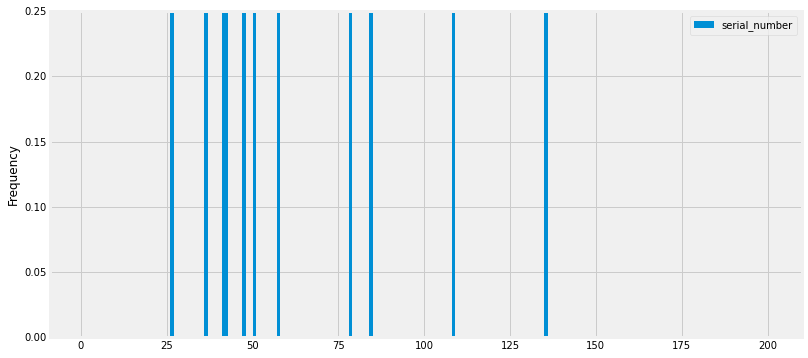

In [24]:
plot_serial_numbers(one_resample)

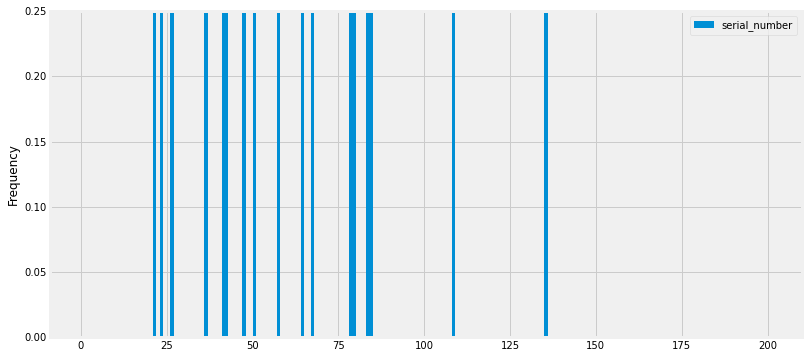

In [25]:
plot_serial_numbers(observations)

#### Question 2.3
Which of the following are true:
1. In the plot of the resample, there are no bars at locations that weren't there in the plot of the original observations.
2. In the plot of the original observations, there are no bars at locations that weren't there in the plot of the resample.
3. The resample has exactly one copy of each serial number.
4. The original observations had exactly one copy of each serial number.

Assign `true_statements` to a list of the correct statements

In [26]:
true_statements = [1,4]

In [27]:
grader.check("q23")

q23 passed!

#### Question 2.4
Create 2 more resamples. For each one, plot it as well as compute the max- and mean-based estimates using that resample.

Mean-based estimate for resample 0: 128.8235294117647
Max-based estimate for resample 0: 135
Mean-based estimate for resample 1: 106.82352941176471
Max-based estimate for resample 1: 108


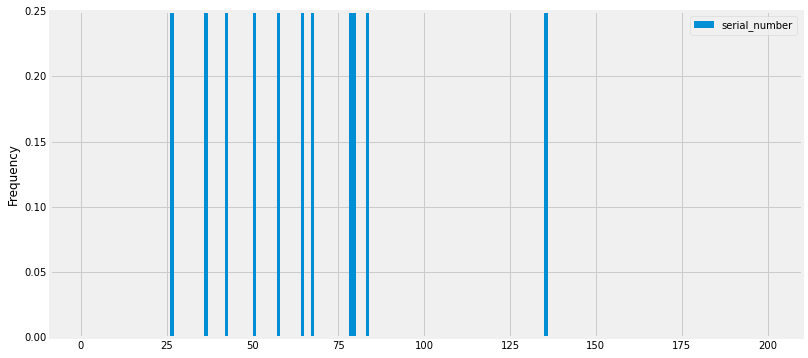

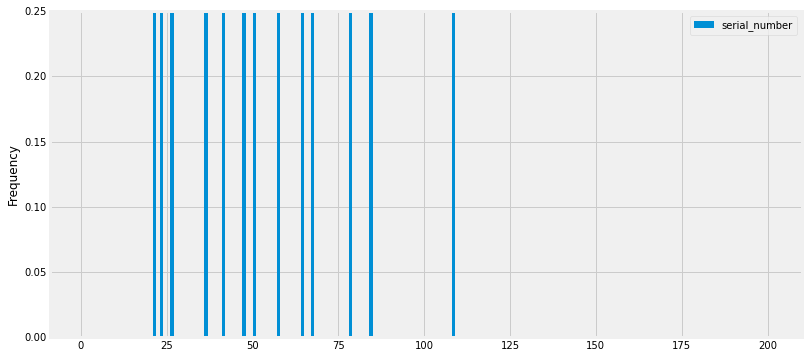

In [28]:
resample_0 = simulate_resample()
plot_serial_numbers(resample_0)

mean_based_estimate_0 = (resample_0.get('serial_number').mean()) * 2
max_based_estimate_0 = resample_0.get('serial_number').max()
print("Mean-based estimate for resample 0:", mean_based_estimate_0)
print("Max-based estimate for resample 0:", max_based_estimate_0)

resample_1 = simulate_resample()
plot_serial_numbers(resample_1)

mean_based_estimate_1 = (resample_1.get('serial_number').mean()) * 2
max_based_estimate_1 = resample_1.get('serial_number').max()
print("Mean-based estimate for resample 1:", mean_based_estimate_1)
print("Max-based estimate for resample 1:", max_based_estimate_1)

You may find that the max-based estimates from the resamples are both exactly 135.  You will probably find that the two mean-based estimates do differ from the sample mean-based estimate (and from each other).

#### Question 2.5
Using probability that you've learned, compute the exact chance that a max-based estimate from one *resample* of our observations sample is 135 and assign it to the variable `resampling_q5` below.  It may be useful to recall that the size of `observations` is 17. 

In [29]:
resampling_q5 = 0.6432138
resampling_q5

0.6432138

In [30]:
grader.check("q25")

q25 passed!

Think about why a mean-based estimate from a resample is less often exactly equal to the mean-based estimate from the original sample as compared to a max-based estimate.

## 3. Simulating with resampling
Since resampling from a sample looks just like sampling from a population, the code should look almost the same.  That means we can write a function that simulates either sampling from a population or resampling from a sample.  If we pass it a population as its argument, it will do the former; if we pass it a sample, it will do the latter.

#### Question 3.1
Write a function called `simulate_estimates`.  It should take 4 arguments:
1. A table from which the data should be sampled.  The table will have 1 column named `"serial_number"`.
2. The size of each sample from that table, an integer.  (For example, to do resampling, we would pass for this argument the number of rows in the table.)
3. A function that computes a statistic of a sample.  This argument is a *function* that takes an array of serial numbers as its argument and returns a number.
4. The number of replications to perform.

It should simulate many samples with replacement from the given table.  (The number of samples is the 4th argument.)  For each of those samples, it should compute the statistic on that sample. Then it should return an array containing each of those statistics.  The code below provides an example use of your function and describes how you can verify that you've written it correctly.

**Hint:** For the next couple of questions, you may find the [percentile function](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) useful.

<AxesSubplot:ylabel='Frequency'>

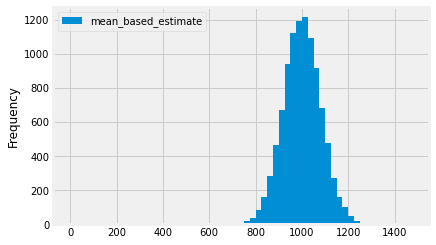

In [31]:
def simulate_estimates(original_table, sample_size, statistic, num_replications):
    # Our implementation of this function took 4 to 5 short lines of code.    
    statistics = np.array([])
    for i in np.arange(num_replications):
        sample = original_table.sample(sample_size, replace=True)
        serial_no = np.array([])
        for i in np.arange(sample_size):
            serial_no = np.append(serial_no, sample.get('serial_number').iloc[i])
        statistics = np.append(statistics, statistic(serial_no))
    return statistics
    
# This should generate an empirical histogram of twice-mean estimates
# of N from samples of size 50 if N is 1000.  This should be a bell-shaped
# curve centered at 1000 with most of its mass in [800, 1200].  To verify your
# answer, make sure that's what you see!
example_estimates = simulate_estimates(
    bpd.DataFrame().assign(serial_number = np.arange(1, 1000+1)),
    50,
    mean_based_estimator,
    10000)
bpd.DataFrame().assign(mean_based_estimate = example_estimates).plot(kind = 'hist', bins=np.arange(0, 1500, 25))

In [32]:
grader.check("q31")

q31 passed!

Now we can go back to the sample we actually observed (the table `observations`) and estimate how much our mean-based estimate of `N` would have varied from sample to sample.

#### Question 3.2
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *mean-based estimates* of `N`.  Use 5,000 replications.  
We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

<AxesSubplot:ylabel='Frequency'>

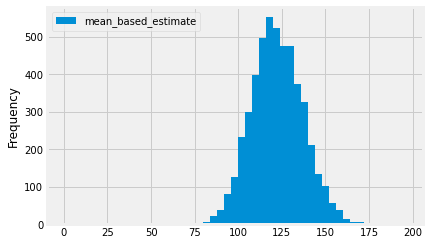

In [33]:
bootstrap_estimates = simulate_estimates(observations, observations.shape[0], mean_based_estimator, 5000)
bpd.DataFrame().assign(mean_based_estimate = bootstrap_estimates).plot(kind = 'hist', bins=np.arange(0, 200, 4)) 

In [34]:
grader.check("q32")

q32 passed!

#### Question 3.3
Compute an interval that covers the middle 95% of the bootstrap estimates.  Verify that your interval looks like it covers 95% of the area in the histogram above.

In [35]:
left_end = np.percentile(bootstrap_estimates, 2.5)
right_end = np.percentile(bootstrap_estimates, 97.5)
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(left_end, right_end))

Middle 95% of bootstrap estimates: [94.941176, 152.005882]


In [36]:
grader.check("q33")

q33 passed!

#### Question 3.4
Let's say that `N` was actually 150!  Write code that simulates the sampling and bootstrapping process again, as follows:

1. Generate a new set of random observations the Allies might have seen by sampling from the population table we have created for you below. Make your sample size something reasonable.
2. Compute an estimate of `N` from these new observations, using `mean_based_estimator`.
3. Using only the new observations, compute 5,000 bootstrap estimates of `N`.
4. Plot these bootstrap estimates and compute an interval covering the middle 95%.

In [37]:
population = bpd.DataFrame().assign(serial_number = np.arange(1, 150+1))
new_observations = population.sample(70)
new_bootstrap_estimates = simulate_estimates(new_observations, new_observations.shape[0], mean_based_estimator, 5000)

#for i in np.arange(5000):
#    new_samples = new_observations.sample(new_observations.shape[0], replace=True)
#    serial_no = np.array([])
#    for i in np.arange(new_samples.shape[0]):
#        serial_no = np.append(serial_no, new_samples.get('serial_number').iloc[i])
#        new_statistics = np.append(new_statistics, mean_based_estimator(serial_no))


new_left_end = np.percentile(new_bootstrap_estimates, 2.5)
new_right_end = np.percentile(new_bootstrap_estimates, 97.5)

print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(new_left_end, new_right_end))

Middle 95% of bootstrap estimates: [139.257143, 179.773571]


In [38]:
grader.check("q34")

q34 passed!

#### Question 3.5
If you ran your cell above many, many times, approximately what percentage of your 95% confidence intervals will include `N`?  Assign either 1, 2, 3, or 4 to the variable `simulating_q5` below. 
1. 100%
2. 95%
3. 5%
4. It's impossible to tell.

In [39]:
simulating_q5 = 2

In [40]:
grader.check("q35")

q35 passed!

# Finish Line

Congratulations! You are done with lab06

To submit your assignment:

1. Select `Kernel -> Restart & Run All` to ensure that you have executed all cells, including the test cells.
2. Read through the notebook to make sure everything is fine and all tests passed.
3. Run the cell below to run all tests, and make sure that they all pass.
4. Download your notebook using `File -> Download as -> Notebook (.ipynb)`, then upload your notebook to Gradescope.

In [41]:
# For your convenience, you can run this cell to run all the tests at once!
grader.check_all()

q01 passed!

q02 passed!

q03 passed!

q11 passed!

q13 passed!

q14 passed!

q15 passed!

q16 passed!

q21 passed!

q23 passed!

q25 passed!

q31 passed!

q32 passed!

q33 passed!

q34 passed!

q35 passed!